In [4]:
import pandas as pd
import numpy as np
import re
from textblob import TextBlob 
from textblob import Word
from wordcloud import WordCloud 
import matplotlib.pyplot as plt

In [ ]:
# model building package
from pprint import pprint

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer

from textblob import Word

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [5]:
data = pd.read_csv("JanDec2021.csv")

In [6]:
data.tail(3)

,Unnamed: 0,id,conversation_id,created_at,date,time,user_id,username,name,place,...,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,thumbnail,reply_to
250555,250555,1344796598061170689,1344796598061170689,2021-01-01 00:04:28 UTC,2021-01-01,00:04:28,1310851241090543618,adda4n,Adda4News,NaN,...,0,0,[],[],https://twitter.com/Adda4N/status/134479659806...,False,NaN,0,NaN,[]
250556,250556,1344796009998680065,1344796009998680065,2021-01-01 00:02:08 UTC,2021-01-01,00:02:08,831434018327453700,yonsolitary,🎗⏳The Solitary Reaper🕉🍀🇮🇳🇦🇺#FreeAssangeNOW,NaN,...,2,0,[],[],https://twitter.com/YonSolitary/status/1344796...,False,NaN,1,https://pbs.twimg.com/media/Eqms1KSUYAA5ycq.jpg,[]
250557,250557,1344795483579944960,1344795483579944960,2021-01-01 00:00:03 UTC,2021-01-01,00:00:03,240649814,timesnow,TIMES NOW,NaN,...,5,20,[],[],https://twitter.com/TimesNow/status/1344795483...,False,NaN,0,NaN,[]


In [7]:
data = data.drop('Unnamed: 0', 1)

In [8]:
data.shape

(250558, 25)

In [9]:
data.dtypes

id                  int64
conversation_id     int64
created_at         object
date               object
time               object
user_id             int64
username           object
name               object
place              object
tweet              object
language           object
mentions           object
urls               object
photos             object
replies_count       int64
retweets_count      int64
likes_count         int64
hashtags           object
cashtags           object
link               object
retweet              bool
quote_url          object
video               int64
thumbnail          object
reply_to           object
dtype: object

In [10]:
data.tweet

0         Double mutation Covid variant in India may spr...
1         The staff members of the Covid centre organise...
2         Harsh Vardhan receives second COVID-19 vaccine...
3         लोगों ने कोरोना के सारे प्रोटोकॉल की धज्जियां ...
4         #reopendu India has two vaccine of covid 19 so...
                                ...                        
250553    Covid inflated salaries in sales, legal, tech ...
250554    Ford Motor Co said on Thursday it was calling ...
250555    BJP’s GHMC corporator-elect succumbs to Covid-...
250556    A discussion on "Multi-Layered Marginality: Un...
250557    Report | 'Probably we will have a Happy New Ye...
Name: tweet, Length: 250558, dtype: object

In [11]:
data.language.unique()

array(['en', 'hi', 'es', 'in', 'und', 'gu', 'pt', 'ja', 'cs', 'tl', 'ta',
       'it', 'ro', 'mr', 'et', 'sv', 'pl', 'ca', 'pa', 'nl', 'no', 'or',
       'ur', 'zh', 'da', 'fr', 'kn', 'te', 'el', 'bn', 'ml', 'tr', 'de',
       'ht', 'ru', 'ar', 'eu', 'ne', 'si', 'is', 'vi', 'sl', 'fi', 'lt',
       'cy', 'uk', 'ko', 'hu', 'fa', 'my', 'ps', 'th', 'sr', 'lo'],
      dtype=object)

In [12]:
data_en = data[data.language == 'en']
data_en = data_en.reset_index(drop=True)

In [13]:
data_en.tweet[1]

'The staff members of the Covid centre organised an alcohol party at the facility near Mumbai at a time when the city is tackling a surge in coronavirus cases. #Maharashtra #coronavirus (@mustafashk)  https://t.co/j9Ux2pVSgM'

In [14]:
data_en[data_en.columns[data_en.isnull().any()]].isnull().sum()

name              9
place        220803
quote_url    211255
thumbnail    167753
dtype: int64

In [15]:
# clean the text
def cleantext(text):
    text = re.sub(r'@[A-Za-z0-9]+', "", text) #remove any mentions
    text = re.sub(r'#', '', text) #remove hashtag
    text = re.sub(r'https?:\/\/\S+','',text) #remove hyperlink
    return text

In [16]:
data_en['tweet'] = data_en['tweet'].apply(cleantext)

In [17]:
data_en.hashtags[3].strip('][').split(', ')[0]

"'reopendu'"

In [29]:
data_en.columns

Index(['id', 'conversation_id', 'created_at', 'date', 'time', 'user_id',
       'username', 'name', 'place', 'tweet', 'language', 'mentions', 'urls',
       'photos', 'replies_count', 'retweets_count', 'likes_count', 'hashtags',
       'cashtags', 'link', 'retweet', 'quote_url', 'video', 'thumbnail',
       'reply_to'],
      dtype='object')

In [19]:
data_en['hashtags']=data_en.hashtags.apply(lambda x: x.strip('][').split(', '))

In [30]:
data_en['hashtags'][3]

["'reopendu'", "'ask_pc_joshi'"]

In [21]:
data_en.iloc[:10].hashtags.apply(pd.Series)\
    .merge(data_en[['id','tweet',"hashtags"]], left_index = True, right_index = True)\
    .drop(["hashtags"], axis = 1) \
    .melt(id_vars = ['id','tweet'], value_name = "hashtags")\
    .replace('', np.nan) \
    .dropna()\
    .drop(['variable'],axis=1) \
    .sort_values(by='id', ascending=True)\
    .reset_index(drop=True)

,id,tweet,hashtags
0,1376831420476219395,India is all set to rule the Post COVID Era BS...,'bsnlnoatmanirbharbharat'
1,1376831560289198082,Continue following COVID appropriate behavior ...,'covid19'
2,1376831560289198082,Continue following COVID appropriate behavior ...,'unite2fightcorona'
3,1376831560289198082,Continue following COVID appropriate behavior ...,'railparivar'
4,1376831822437392386,"95,590 Covid 19 vaccine doses utilised till Ma...",'goahealthminister'
5,1376831822437392386,"95,590 Covid 19 vaccine doses utilised till Ma...",'covidvaccine'
6,1376831822437392386,"95,590 Covid 19 vaccine doses utilised till Ma...",'panaji'
7,1376831946815250434,reopendu India has two vaccine of covid 19 so ...,'reopendu'
8,1376831946815250434,reopendu India has two vaccine of covid 19 so ...,'ask_pc_joshi'
9,1376832020920246273,The staff members of the Covid centre organise...,'maharashtra'


In [22]:
data_en1=data_en.hashtags.apply(pd.Series) \
    .merge(data_en[['id','tweet',"hashtags"]], left_index = True, right_index = True)\
    .drop(["hashtags"], axis = 1) \
    .melt(id_vars = ['id','tweet'], value_name = "hashtags")\
    .replace('', np.nan) \
    .dropna()\
    .drop(['variable'],axis=1) \
    .sort_values(by='id', ascending=True)\
    .reset_index(drop=True)

In [23]:
data_en1['hashtags']=data_en1['hashtags'].apply(lambda x: x[1:-1])

In [24]:
data_en1.tail(2)

,id,tweet,hashtags
229192,1376832020920246273,The staff members of the Covid centre organise...,coronavirus
229193,1376832020920246273,The staff members of the Covid centre organise...,maharashtra


In [25]:
pd.merge(data_en1,data_en.drop(columns=['hashtags']),how='left').to_csv('hashtags.csv')

In [26]:
data_en.to_csv('data_en.csv')

In [154]:
data_en['retweets_count'].max()

48477

In [162]:
for i in data_en[['tweet','retweets_count']].sort_values(by='retweets_count',ascending=False).head(10).index:
    print(data_en['name'].iloc[i])
    print(data_en['tweet'].iloc[i])

Narendra Modi
Took my first dose of the COVID-19 vaccine at AIIMS.   Remarkable how our doctors and scientists have worked in quick time to strengthen the global fight against COVID-19.   I appeal to all those who are eligible to take the vaccine. Together, let us make India COVID-19 free!  
Bill Gates
It’s great to see India’s leadership in scientific innovation and vaccine manufacturing capability as the world works to end the COVID-19 pandemic   
Narendra Modi
Was happy to receive a call from my friend .  Assured him that India would do its best to facilitate supplies of COVID vaccines sought by Canada. We also agreed to continue collaborating on other important issues like Climate Change and the global economic recovery.
Narendra Modi
A decisive turning point to strengthen a spirited fight!   DCGI granting approval to vaccines of  and  accelerates the road to a healthier and COVID-free nation.   Congratulations India.   Congratulations to our hardworking scientists and innovators.


# Visualization

In [27]:
from PIL import Image
twitter_mask = np.array(Image.open("/Users/lixueting/Desktop/MSBA/BANA 275/Project/twitter_mask.png"))

In [28]:
data_en1['hashtags']

0               newyearseve
1               newyear2021
2                   gujarat
3                     covid
4                     india
                ...        
229189    goahealthminister
229190         ask_pc_joshi
229191             reopendu
229192          coronavirus
229193          maharashtra
Name: hashtags, Length: 229194, dtype: object

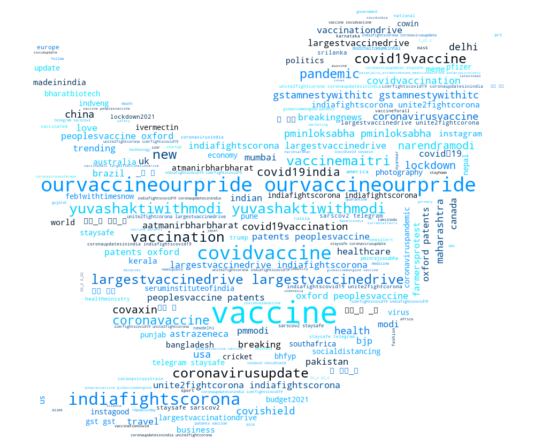

In [345]:
import random

removal=['covid','india','case','coronavirus','u','corona','covid19','covid_19']
hastags=[word for word in data_en1['hashtags'] if not word in removal]

def color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(200, 250%%, %d%%)" % random.randint(1, 50)

wc = WordCloud(width = 800, height = 400, mask=twitter_mask,
                background_color ='White', 
                relative_scaling=0.5,
                min_font_size = 5,random_state=10).generate(' '.join(hastags))

# show
plt.figure(figsize = (10, 6))
plt.imshow(wc.recolor(color_func=color_func, random_state=3),
           interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [350]:
data_en[['retweets_count','likes_count']].describe()

,retweets_count,likes_count
count,221026.000000,221026.000000
mean,5.057016,22.715884
std,153.823696,782.878683
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,2.000000
max,48477.000000,234589.000000


In [352]:
data_en.to_csv('data_en.csv')

In [361]:
# clean the text
def cleantext(text):
    #remove any mentions
    text = re.sub(r'@[A-Za-z0-9]+', ' ', text) 
    #remove hashtag
    text = re.sub(r'#', ' ', text)
    #removing html 
    text = re.sub(r'&\S+',' ',text)
    #remove hyperlink
    text = re.sub(r'https?://\S+',' ',text) 
    #keep only alpha  
    text = re.sub(r'[^a-zA-Z]',' ',text) 
    # convert to lower case
    words = [word.lower() for word in text.split()]   
    #filter out stop words 
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if not word in stop_words]
    #Lemmatisation
    lem = WordNetLemmatizer()
    words = [lem.lemmatize(word) for word in words]
    #consider words with length greatert than 1
    words = [word for word in words if len(word)>1]
    #remove custom stop words 
    custom_words = ['covid','india','case','coronavirus','u','corona','19']
    words = [word for word in words if not word in custom_words]
    return words

In [140]:
data_en['tweet'][0]

'Double mutation Covid variant in India may spread to other countries, doctor says  '

In [141]:
cleantext(data_en['tweet'][0])

['double', 'mutation', 'variant', 'may', 'spread', 'country', 'doctor', 'say']

**Celebrity**

In [396]:
texts1=[]
for text in data_en[data_en['likes_count']>10]['tweet']:
    texts1.append(' '.join(cleantext(text)))

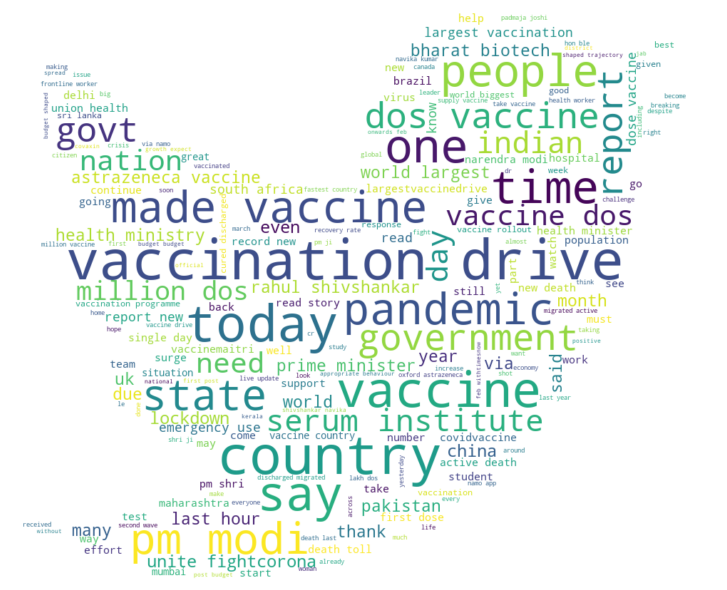

In [397]:
wc = WordCloud(width = 800, height = 400, mask=twitter_mask,
                background_color ='White', 
                relative_scaling=0.5,
               min_font_size = 5,random_state=10).generate(' '.join(texts1))

# show
plt.figure(figsize = (12, 8))
plt.imshow(wc.recolor(random_state=3),
           interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [399]:
texts=[]
for text in data_en[data_en['likes_count']<=10]['tweet']:
    texts.append(' '.join(cleantext(text)))

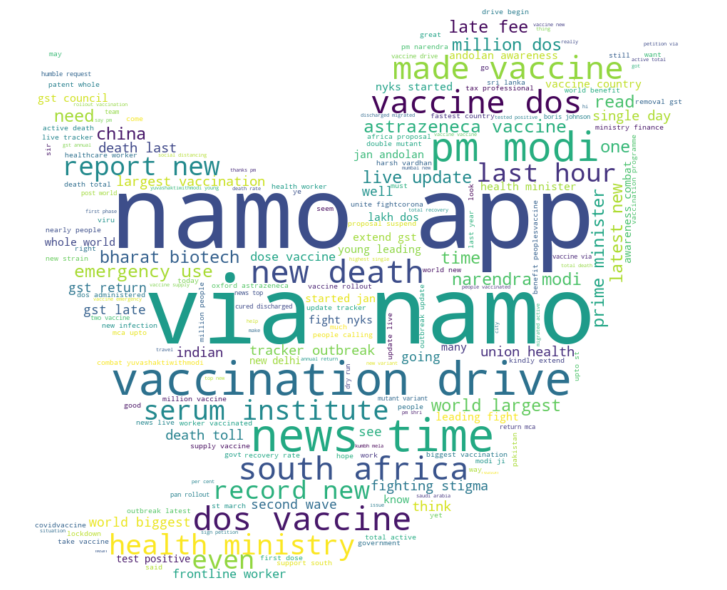

In [400]:
wc = WordCloud(width = 800, height = 400, mask=twitter_mask,
                background_color ='White', 
                relative_scaling=0.5,
               min_font_size = 5,random_state=10).generate(' '.join(texts))

# show
plt.figure(figsize = (12, 8))
plt.imshow(wc.recolor(random_state=3),
           interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

# Location Extraction

In [39]:
topic=pd.read_csv('/Users/lixueting/Downloads/tweet_topic_dataset.csv')

In [42]:
topic[['id','tweet','dominant_topic','perc_contribution']].tail()

,id,tweet,dominant_topic,perc_contribution
221021,1344797716967288832,"Covid inflated salaries in sales, legal, tech ...",income/money/finance,0.537855
221022,1344797200690393089,Ford Motor Co said on Thursday it was calling ...,income/money/finance,0.716487
221023,1344796598061170689,BJP’s GHMC corporator-elect succumbs to Covid-...,covid cases and death,0.555728
221024,1344796009998680065,"A discussion on ""Multi-Layered Marginality: Un...",covid cases and death,0.614857
221025,1344795483579944960,Report | 'Probably we will have a Happy New Ye...,covid cases and death,0.572773


In [43]:
import spacy
nlp = spacy.load('en_core_web_sm')

/Users/lixueting/opt/miniconda3/lib/python3.7/site-packages/spacy/util.py:275: UserWarning: [W031] Model 'en_core_web_sm' (2.2.0) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.2). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [44]:
# clean the text
from nltk.corpus import stopwords

def cleantext(text):
    #remove any mentions
    text = re.sub(r'@[A-Za-z0-9]+', ' ', text) 
    #remove hashtag
    text = re.sub(r'#', ' ', text)
    #removing html 
    text = re.sub(r'&\S+',' ',text)
    #remove hyperlink
    text = re.sub(r'https?://\S+',' ',text) 
    #keep only alpha  
    text = re.sub(r'[^a-zA-Z]',' ',text) 
    # convert to lower case
    words = [word.lower() for word in text.split()]   
    #filter out stop words 
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if not word in stop_words]
    #Lemmatisation
    lem = WordNetLemmatizer()
    words = [lem.lemmatize(word) for word in words]
    #consider words with length greatert than 1
    words = [word for word in words if len(word)>1]
    #remove custom stop words 
    custom_words = ['covid','india','case','coronavirus','u','corona']
    words = [word for word in words if not word in custom_words]
    return words

In [45]:
data_en.tail()

,id,conversation_id,created_at,date,time,user_id,username,name,place,tweet,...,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,thumbnail,reply_to
221021,1344797716967288832,1344797716967288832,2021-01-01 00:08:55 UTC,2021-01-01,00:08:55,773485929969414148,sarang143u,Sarang Pokhare,NaN,"Covid inflated salaries in sales, legal, tech ...",...,0,0,[],[],https://twitter.com/sarang143u/status/13447977...,False,NaN,0,NaN,[]
221022,1344797200690393089,1344797200690393089,2021-01-01 00:06:52 UTC,2021-01-01,00:06:52,2508863607,randylangworthy,Fastguy,NaN,Ford Motor Co said on Thursday it was calling ...,...,1,0,[],[],https://twitter.com/RandyLangworthy/status/134...,False,NaN,0,NaN,[]
221023,1344796598061170689,1344796598061170689,2021-01-01 00:04:28 UTC,2021-01-01,00:04:28,1310851241090543618,adda4n,Adda4News,NaN,BJP’s GHMC corporator-elect succumbs to Covid-...,...,0,0,[],[],https://twitter.com/Adda4N/status/134479659806...,False,NaN,0,NaN,[]
221024,1344796009998680065,1344796009998680065,2021-01-01 00:02:08 UTC,2021-01-01,00:02:08,831434018327453700,yonsolitary,🎗⏳The Solitary Reaper🕉🍀🇮🇳🇦🇺#FreeAssangeNOW,NaN,"A discussion on ""Multi-Layered Marginality: Un...",...,2,0,[],[],https://twitter.com/YonSolitary/status/1344796...,False,NaN,1,https://pbs.twimg.com/media/Eqms1KSUYAA5ycq.jpg,[]
221025,1344795483579944960,1344795483579944960,2021-01-01 00:00:03 UTC,2021-01-01,00:00:03,240649814,timesnow,TIMES NOW,NaN,Report | 'Probably we will have a Happy New Ye...,...,5,20,[],[],https://twitter.com/TimesNow/status/1344795483...,False,NaN,0,NaN,[]


In [46]:
cities=pd.read_excel('/Users/lixueting/Desktop/MSBA/BANA 275/Project/India city.xlsx')
cities

,city,lat,lng
0,Delhi,28.6600,77.2300
1,Mumbai,18.9667,72.8333
2,Kolkata,22.5411,88.3378
3,Bangalore,12.9699,77.5980
4,Chennai,13.0825,80.2750
...,...,...,...
428,Manali,32.2044,77.1700
429,Amarkantak,22.6751,81.7596
430,Pedda Nandipadu,16.0728,80.3294
431,Loutolim,15.3300,73.9800


In [47]:
states=pd.read_csv('/Users/lixueting/Desktop/MSBA/BANA 275/Project/list_of_cities_and_towns_in_india-834j.csv')
states=states[:-2][['State','Name of City']]
states=states.rename(columns={'Name of City':'city'})

In [48]:
locations=pd.merge(cities,states)
locations=locations.rename(columns={'State':'state'})
locations

,city,lat,lng,state
0,Delhi,28.6600,77.2300,Delhi
1,Mumbai,18.9667,72.8333,Maharashtra
2,Kolkata,22.5411,88.3378,West Bengal
3,Chennai,13.0825,80.2750,Tamil Nadu
4,Hyderabad,17.3667,78.4667,Telangana
...,...,...,...,...
219,Fatehpur Sikri,27.0911,77.6611,Uttar Pradesh
220,Umaria,23.5245,80.8365,Madhya Pradesh
221,Pedana,16.2667,81.1667,Andhra Pradesh
222,Uran,18.8900,72.9500,Maharashtra


In [49]:
city_list=list(cities['city'])
city_lower=[city.lower() for city in city_list]

In [50]:
city_lower[10]

'jaipur'

In [54]:
index=[]
for i in range(len(data_en)):
    words=cleantext(data_en['tweet'][i])
    #print(i)
    for word in words:
        if word in city_lower:
            #print(word)
            index.append(i)
        else:
            pass
len(set(index))

15013

In [55]:
city_index=list(set(index))
city_index=sorted(city_index)
city_index[150]

1381

In [56]:
data_city=data_en[['tweet','id']].iloc[city_index]
# data_city['tweet number']=data_city.index
data_city=data_city.reset_index(drop=True)
data_city.tail()

,tweet,id
15008,Fighting Stigma : News headlines for Dec 31: ...,1344816243677663232
15009,Year of Virus ends in Maharashtra with 19.3 la...,1344816242851418116
15010,Fighting Stigma : Dry run for Covid-19 vaccin...,1344801519993032707
15011,BJP’s GHMC corporator-elect succumbs to Covid-...,1344796598061170689
15012,"A discussion on ""Multi-Layered Marginality: Un...",1344796009998680065


In [57]:
city=[]
for i in range(len(data_city['tweet'])):
    words=cleantext(data_city['tweet'][i])
    #print(i)
    words_city=[]
    for word in words:
        if word in city_lower:
            words_city.append(word)
        else:
            pass
    city.append(list(set(words_city)))

In [58]:
data_city['city']=city
data_city.tail(10)

,tweet,id,city
15003,India 2020: No brakes on trade and commerce de...,1344829672891170816,"[mumbai, delhi]"
15004,India 2020: No brakes on trade and commerce de...,1344829216286670848,[jammu]
15005,"""Preparations are in last stages for the vacci...",1344828774953619462,[rajkot]
15006,India is likely to have a Covid-19 vaccine in ...,1344818135162093568,[drug]
15007,India is likely to have a Covid-19 vaccine in ...,1344816790312951812,[drug]
15008,Fighting Stigma : News headlines for Dec 31: ...,1344816243677663232,[rajkot]
15009,Year of Virus ends in Maharashtra with 19.3 la...,1344816242851418116,[thane]
15010,Fighting Stigma : Dry run for Covid-19 vaccin...,1344801519993032707,[delhi]
15011,BJP’s GHMC corporator-elect succumbs to Covid-...,1344796598061170689,[hyderabad]
15012,"A discussion on ""Multi-Layered Marginality: Un...",1344796009998680065,[chennai]


In [59]:
data_city['tweet'].iloc[-1]

'A discussion on "Multi-Layered Marginality: Understanding Exclusion in Covid-19 times" comducted by US Consulate General in Chennai, India  All participants are very rich, their rooms look new &amp; not even one patch of water leak in their ceilings &amp; walls  Welcome to Wokeness 2021  '

In [60]:
data_city['city'].iloc[4]

['mumbai', 'lucknow']

In [61]:
data_city[data_city['city']=='Ahmadabad']['city']

Series([], Name: city, dtype: object)

In [62]:
data_city=data_city.city.apply(pd.Series) \
    .merge(data_city, left_index = True, right_index = True) \
    .drop(["city"], axis = 1) \
    .melt(id_vars = ['id','tweet'], value_name = "city") \
    .dropna() \
    .drop(['variable'],axis=1) \
    .sort_values(by='id', ascending=True)\
    .reset_index(drop=True)

In [63]:
data_city['city']=data_city['city'].map(lambda x: x[0].upper() + x[1:])

In [64]:
data_city=pd.merge(data_city,locations,how='left',on='city')

In [65]:
data_city.head()

,id,tweet,city,lat,lng,state
0,1344796009998680065,"A discussion on ""Multi-Layered Marginality: Un...",Chennai,13.0825,80.2750,Tamil Nadu
1,1344796598061170689,BJP’s GHMC corporator-elect succumbs to Covid-...,Hyderabad,17.3667,78.4667,Telangana
2,1344801519993032707,Fighting Stigma : Dry run for Covid-19 vaccin...,Delhi,28.6600,77.2300,Delhi
3,1344816242851418116,Year of Virus ends in Maharashtra with 19.3 la...,Thane,19.1800,72.9633,Maharashtra
4,1344816243677663232,Fighting Stigma : News headlines for Dec 31: ...,Rajkot,22.2969,70.7984,Gujarat


In [66]:
data_city=data_city.rename(columns={'State':'state'})

In [67]:
data_city.tail()

,id,tweet,city,lat,lng,state
16762,1376830276974870528,We were stuffed in a bus after landing in mumb...,Mumbai,18.9667,72.8333,Maharashtra
16763,1376830515232182286,"_Support In Kolkata, India we find the follow...",Kolkata,22.5411,88.3378,West Bengal
16764,1376831822437392386,"95,590 Covid 19 vaccine doses utilised till Ma...",Panaji,15.4800,73.8300,Goa
16765,1376831824232476672,Conducted Punjab dissemination at Ludhiana und...,Ludhiana,30.9083,75.8486,Punjab
16766,1376832020920246273,The staff members of the Covid centre organise...,Mumbai,18.9667,72.8333,Maharashtra


In [175]:
set(data_city[data_city['state'].isna()]['city'])

{'Abu',
 'Ahmadabad',
 'Ambala',
 'Bali',
 'Bangalore',
 'Belgaum',
 'Bellary',
 'Bhayandar',
 'Bhilai',
 'Bhubaneshwar',
 'Bidar',
 'Bulandshahr',
 'Calicut',
 'Chanda',
 'Daman',
 'Darjeeling',
 'Davangere',
 'Deo',
 'Dharmsala',
 'Dholka',
 'Diu',
 'Drug',
 'Durgapur',
 'Dwarka',
 'Fatehpur',
 'Gangtok',
 'Ghaziabad',
 'Gorakhpur',
 'Gulbarga',
 'Handwara',
 'Hassan',
 'Hathras',
 'Hubli',
 'Itanagar',
 'Jaisalmer',
 'Jalgaon',
 'Jaunpur',
 'Kairana',
 'Kalyan',
 'Kalyani',
 'Kamarhati',
 'Kavaratti',
 'Khajuraho',
 'Kolhapur',
 'Kota',
 'Kulgam',
 'Manali',
 'Mangalore',
 'Meghraj',
 'Mirzapur',
 'Muzaffarnagar',
 'Nalgonda',
 'Nanded',
 'Nasik',
 'Panchgani',
 'Puducherry',
 'Pushkar',
 'Raichur',
 'Secunderabad',
 'Shimoga',
 'Tanjore',
 'Tuticorin',
 'Ulhasnagar'}

**STATE**

In [68]:
state_list=list(locations['state'])
state_lower=[state.lower() for state in state_list]

In [69]:
index=[]
for i in range(len(data_en)):
    words=cleantext(data_en['tweet'][i])
    #print(i)
    for word in words:
        if word in state_lower:
            #print(word)
            index.append(i)
        else:
            pass
len(set(index))

15243

In [70]:
state_index=list(set(index))
state_index=sorted(state_index)
state_index[150]

754

In [71]:
data_state=data_en[['id','tweet']].iloc[state_index]
#data_state['id']=data_state.index
data_state=data_state.reset_index(drop=True)
data_state.tail()

,id,tweet
15238,1344816243677663232,Fighting Stigma : News headlines for Dec 31: ...
15239,1344816242851418116,Year of Virus ends in Maharashtra with 19.3 la...
15240,1344811085891854338,COVID-19 vaccination: Dry run in five district...
15241,1344801519993032707,Fighting Stigma : Dry run for Covid-19 vaccin...
15242,1344797884680523776,"2020 was pretty long &amp; tiring, but we hope..."


In [72]:
state=[]
for i in range(len(data_state['tweet'])):
    words=cleantext(data_state['tweet'][i])
    #print(i)
    words_state=[]
    for word in words:
        if word in state_lower:
            words_state.append(word)
        else:
            pass
    state.append(list(set(words_state)))

In [73]:
data_state['state']=state
data_state.tail()

,id,tweet,state
15238,1344816243677663232,Fighting Stigma : News headlines for Dec 31: ...,[gujarat]
15239,1344816242851418116,Year of Virus ends in Maharashtra with 19.3 la...,[maharashtra]
15240,1344811085891854338,COVID-19 vaccination: Dry run in five district...,[karnataka]
15241,1344801519993032707,Fighting Stigma : Dry run for Covid-19 vaccin...,[delhi]
15242,1344797884680523776,"2020 was pretty long &amp; tiring, but we hope...",[gujarat]


In [74]:
data_state=data_state.state.apply(pd.Series) \
    .merge(data_state, left_index = True, right_index = True) \
    .drop(["state"], axis = 1) \
    .melt(id_vars = ['id','tweet'], value_name = "state") \
    .dropna() \
    .drop(['variable'],axis=1) \
    .sort_values(by='id', ascending=True)\
    .reset_index(drop=True)
data_state.tail()

,id,tweet,state
17949,1376829502857220096,Uttarakhand: Maa Purnagiri fair will start tod...,uttarakhand
17950,1376830276974870528,We were stuffed in a bus after landing in mumb...,maharashtra
17951,1376830443090108417,In Odisha Clg. authority &amp; admin believes...,odisha
17952,1376831824232476672,Conducted Punjab dissemination at Ludhiana und...,punjab
17953,1376832020920246273,The staff members of the Covid centre organise...,maharashtra


In [75]:
data_state['state']=data_state['state'].map(lambda x: x[0].upper() + x[1:])

In [76]:
data_state.tail()

,id,tweet,state
17949,1376829502857220096,Uttarakhand: Maa Purnagiri fair will start tod...,Uttarakhand
17950,1376830276974870528,We were stuffed in a bus after landing in mumb...,Maharashtra
17951,1376830443090108417,In Odisha Clg. authority &amp; admin believes...,Odisha
17952,1376831824232476672,Conducted Punjab dissemination at Ludhiana und...,Punjab
17953,1376832020920246273,The staff members of the Covid centre organise...,Maharashtra


In [77]:
data_location=pd.merge(data_city,data_state,on=['id','tweet','state'],how='outer')

In [78]:
data_location=data_location.sort_values(by='id',ascending=True).reset_index(drop=True)


In [80]:
data_location.tail(10)

,id,tweet,city,lat,lng,state
28136,1376827431948935169,SIKHS IN INDIA ATTACK COPSLast year same peop...,NaN,NaN,NaN,Maharashtra
28137,1376827539360899075,Maharashtra: Mortality rate of COVID patients ...,NaN,NaN,NaN,Maharashtra
28138,1376829502857220096,Uttarakhand: Maa Purnagiri fair will start tod...,NaN,NaN,NaN,Uttarakhand
28139,1376830276974870528,We were stuffed in a bus after landing in mumb...,Lucknow,26.8470,80.9470,Uttar Pradesh
28140,1376830276974870528,We were stuffed in a bus after landing in mumb...,Mumbai,18.9667,72.8333,Maharashtra
28141,1376830443090108417,In Odisha Clg. authority &amp; admin believes...,NaN,NaN,NaN,Odisha
28142,1376830515232182286,"_Support In Kolkata, India we find the follow...",Kolkata,22.5411,88.3378,West Bengal
28143,1376831822437392386,"95,590 Covid 19 vaccine doses utilised till Ma...",Panaji,15.4800,73.8300,Goa
28144,1376831824232476672,Conducted Punjab dissemination at Ludhiana und...,Ludhiana,30.9083,75.8486,Punjab
28145,1376832020920246273,The staff members of the Covid centre organise...,Mumbai,18.9667,72.8333,Maharashtra


In [102]:
data_location[data_location['id']==1376832020920246273]

,id,tweet,city,lat,lng,state


In [127]:
topic=topic[['id','tweet','dominant_topic','perc_contribution']]
topic[topic['id']==1344796598061170689]

,id,tweet,dominant_topic,perc_contribution
221023,1344796598061170689,BJP’s GHMC corporator-elect succumbs to Covid-...,covid cases and death,0.555728


In [133]:
location=pd.merge(data_location,topic,how='left',on=['id'])\
    .drop(columns='tweet_x')\
    .rename(columns={'tweet_y':'tweet'})

In [138]:
# To avoid id transfering to scientific notation in csv file
def deal_str(data):
    data = str(data)+"\t"
    return data
location['id'] = location['id'].map(deal_str)

In [136]:
location.tail()

,id,city,lat,lng,state,tweet,dominant_topic,perc_contribution
28141,1376830443090108417\t,NaN,NaN,NaN,Odisha,@otvnews In #Odisha Clg. authority &amp; admin...,covid cases and death,0.969734
28142,1376830515232182286\t,Kolkata,22.5411,88.3378,West Bengal,"@Uber_Support In Kolkata, India we find the f...",covid cases and death,0.856591
28143,1376831822437392386\t,Panaji,15.4800,73.8300,Goa,"95,590 Covid 19 vaccine doses utilised till Ma...",vaccine,0.605198
28144,1376831824232476672\t,Ludhiana,30.9083,75.8486,Punjab,Conducted Punjab dissemination at Ludhiana und...,income/money/finance,0.741512
28145,1376832020920246273\t,Mumbai,18.9667,72.8333,Maharashtra,The staff members of the Covid centre organise...,covid cases and death,0.782251


In [137]:
location.to_csv('covid tweets by location.csv',encoding='utf-8',index=False)